<a href="https://colab.research.google.com/github/pypratikyesankar9/NLP_demystified/blob/main/Named_entity_first_cut_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc

gc.collect()

98

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.svm import SVC


In [19]:
## loading the Dataset
data = pd.read_csv("ner_dataset.csv",encoding="latin1" )

In [20]:
##Dimension check
print(data.head())
print()
data.shape

    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O



(1048575, 4)

In [21]:
##Identifying missing values
data.isnull().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

Data Preprocessing

In [22]:
data = data.fillna(method='ffill')

data['Sentence #'].nunique(), data.Word.nunique(), data.Tag.nunique()

(47959, 35177, 17)

In [23]:
data['Sentence #'].nunique(), data.Word.nunique(), data.Tag.nunique()

(47959, 35177, 17)

In [7]:
data.shape

(1048575, 4)

In [8]:
#### Optional, will show 1 example with spacy as well
##!pip install -U spacy==3.*
##!python -m spacy download en_core_web_sm
##!python -m spacy info

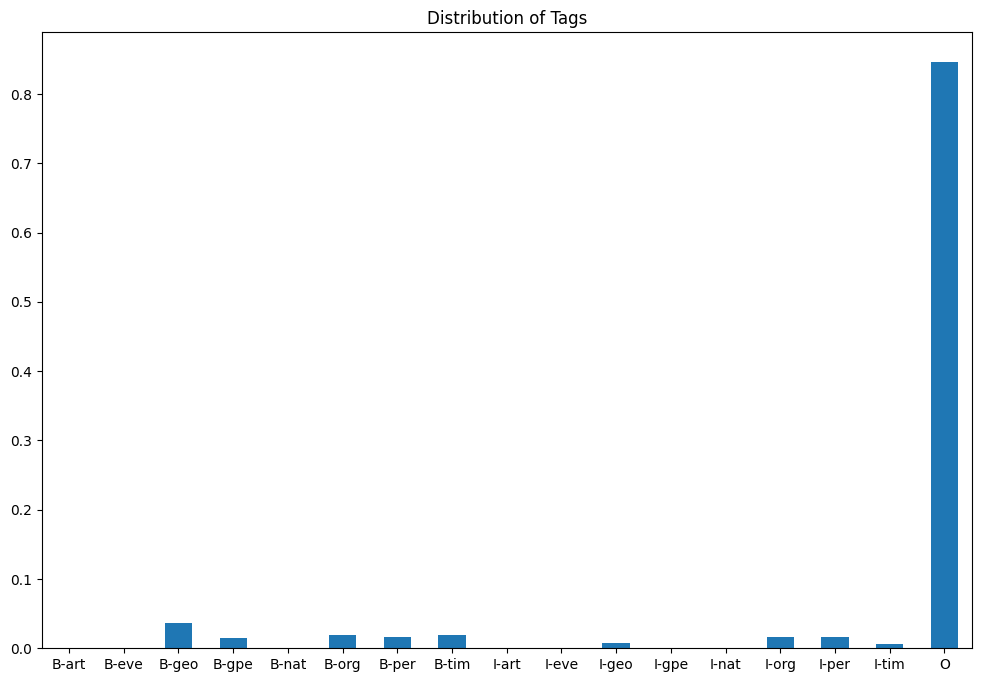

In [ ]:
####Checking the distribution for Tag
bins, counts = np.unique(data.Tag, return_counts=True)
freq_series = pd.Series(counts/len(data))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
ax.set_title('Distribution of Tags')
plt.show()

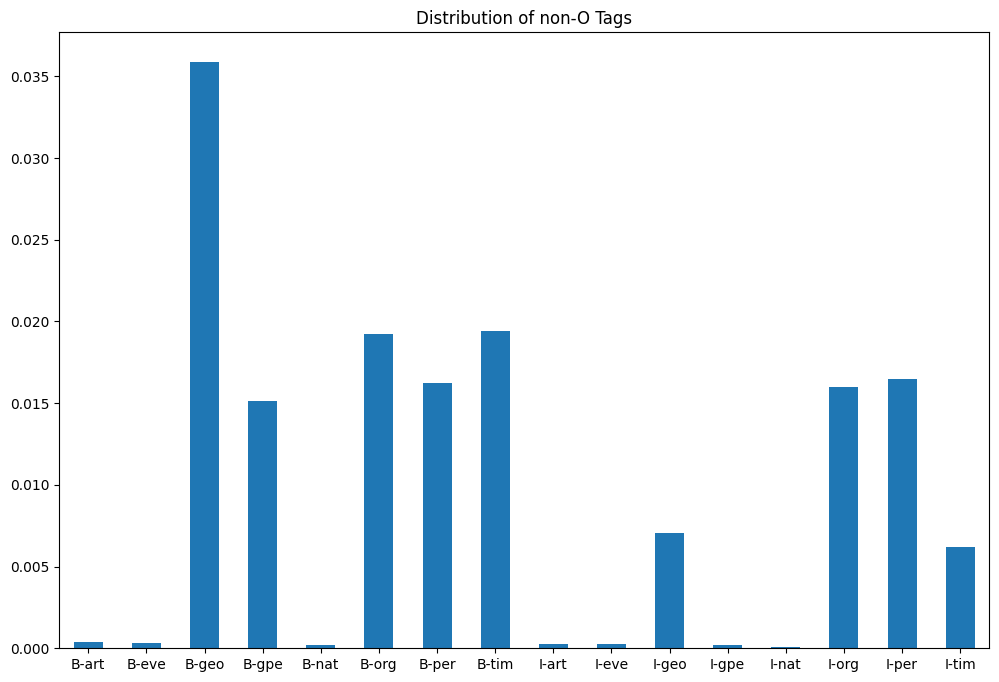

In [ ]:

bins, counts = np.unique(data[data.Tag != 'O'].Tag, return_counts=True)
freq_series = pd.Series(counts/len(data))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
ax.set_title('Distribution of non-O Tags')
plt.show()

In [ ]:
data.groupby('Tag').size().reset_index(name='counts').sort_values(by = 'counts', ascending= False)

,Tag,counts
16,O,887908
2,B-geo,37644
7,B-tim,20333
5,B-org,20143
14,I-per,17251
6,B-per,16990
13,I-org,16784
3,B-gpe,15870
10,I-geo,7414
15,I-tim,6528


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [25]:

data["Sentence #"] = LabelEncoder().fit_transform(data["Sentence #"] )

In [18]:

data.head(30)

,Sentence #,Word,POS,Tag
0,0,Thousands,NNS,O
1,47959,of,IN,O
2,47959,demonstrators,NNS,O
3,47959,have,VBP,O
4,47959,marched,VBN,O
5,47959,through,IN,O
6,47959,London,NNP,B-geo
7,47959,to,TO,O
8,47959,protest,VB,O
9,47959,the,DT,O


In [26]:
data.rename(columns={"Sentence #":"sentence_id","Word":"words","Tag":"labels"}, inplace =True)

In [ ]:
##Lower case for words, and upper case for lables
data["labels"] = data["labels"].str.upper()
data["words"] = data["words"].str.lower()




In [28]:
###
X= data[["sentence_id","words"]]
Y =data["labels"]

In [29]:

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size =0.2)

In [ ]:

#building up train data and test data
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [ ]:
#### Validation data kept separately for final validation
val_data = test_data.copy()

In [ ]:
X2= train_data[["sentence_id","words"]]
Y2 =train_data["labels"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X2,Y2, test_size =0.2)

In [ ]:

#re building the train data and test data
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [ ]:
## dimensions of train, test and validation
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)



(671088, 3)
(167772, 3)
(209715, 3)


In [ ]:
del X
del Y
del X2
del Y2


In [ ]:
%%time
vectorizer = CountVectorizer(stop_words= "english")

CPU times: user 35 µs, sys: 0 ns, total: 35 µs
Wall time: 38.4 µs


In [ ]:
%%time
x= vectorizer.fit_transform(train_data['words'].values.astype('U'))
x_test = vectorizer.transform(test_data['words'].values.astype('U'))
x_val = vectorizer.transform(val_data['words'].values.astype('U'))

CPU times: user 5.31 s, sys: 120 ms, total: 5.43 s
Wall time: 5.49 s


In [ ]:
y = train_data['labels']
y_test = test_data['labels']
y_val = val_data['labels']

In [ ]:
classes = np.unique(y)
classes = classes.tolist()

Linear classifier with SGD

In [ ]:
#training the model
sgd = SGDClassifier()
sgd.partial_fit(x, y, classes)


SGDClassifier()

In [ ]:
#Scoring the model on datasets
y_pred = sgd.predict(x)
y_test_pred = sgd.predict(x_test)
y_val_pred = sgd.predict(x_val)

In [ ]:
print("Train F1-score:", f1_score(y,y_pred,average = "macro"))
print("Test F1-score:", f1_score(y_test,y_test_pred,average = "macro"))
print("Validation F1-score:", f1_score(y_val,y_val_pred,average = "macro"))

Train F1-score: 0.28765913495920076
Test F1-score: 0.28739343386464605
Validation F1-score: 0.28825320714004465


In [ ]:
print(classification_report(y_pred=sgd.predict(x), y_true=y, labels = classes))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ART       0.00      0.00      0.00       252
       B-EVE       0.00      0.00      0.00       210
       B-GEO       0.82      0.47      0.60     24169
       B-GPE       0.92      0.68      0.78     10169
       B-NAT       0.00      0.00      0.00       134
       B-ORG       0.85      0.20      0.32     12812
       B-PER       0.82      0.40      0.54     10940
       B-TIM       0.89      0.64      0.75     13002
       I-ART       0.00      0.00      0.00       184
       I-EVE       0.00      0.00      0.00       178
       I-GEO       0.79      0.31      0.45      4784
       I-GPE       0.00      0.00      0.00       131
       I-NAT       0.00      0.00      0.00        30
       I-ORG       0.65      0.12      0.20     10604
       I-PER       0.81      0.19      0.30     10917
       I-TIM       0.00      0.00      0.00      4119
           O       0.90      1.00      0.95    568453

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
new_classes = classes.copy()
new_classes.pop()
new_classes


['B-ART',
 'B-EVE',
 'B-GEO',
 'B-GPE',
 'B-NAT',
 'B-ORG',
 'B-PER',
 'B-TIM',
 'I-ART',
 'I-EVE',
 'I-GEO',
 'I-GPE',
 'I-NAT',
 'I-ORG',
 'I-PER',
 'I-TIM']

In [ ]:
print(classification_report(y_pred=sgd.predict(x), y_true=y, labels = new_classes))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ART       0.00      0.00      0.00       252
       B-EVE       0.00      0.00      0.00       210
       B-GEO       0.82      0.47      0.60     24169
       B-GPE       0.92      0.68      0.78     10169
       B-NAT       0.00      0.00      0.00       134
       B-ORG       0.85      0.20      0.32     12812
       B-PER       0.82      0.40      0.54     10940
       B-TIM       0.89      0.64      0.75     13002
       I-ART       0.00      0.00      0.00       184
       I-EVE       0.00      0.00      0.00       178
       I-GEO       0.79      0.31      0.45      4784
       I-GPE       0.00      0.00      0.00       131
       I-NAT       0.00      0.00      0.00        30
       I-ORG       0.65      0.12      0.20     10604
       I-PER       0.81      0.19      0.30     10917
       I-TIM       0.00      0.00      0.00      4119

   micro avg       0.85      0.37      0.52    102635
   macro avg       0.41   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##Naive Bayes classifier for multinomial models
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(x, y, classes)


MultinomialNB(alpha=0.01)

In [ ]:
#Scoring the model on datasets
y_pred = nb.predict(x)
y_test_pred = nb.predict(x_test)
y_val_pred = nb.predict(x_val)

In [ ]:
print("Train F1-score:", f1_score(y,y_pred,average = "macro"))
print("Test F1-score:", f1_score(y_test,y_test_pred,average = "macro"))
print("Validation F1-score:", f1_score(y_val,y_val_pred,average = "macro"))

Train F1-score: 0.5086906954845322
Test F1-score: 0.41163096944291777
Validation F1-score: 0.41402026876637693


In [ ]:
print(classification_report(y_pred=y_pred, y_true=y, labels = new_classes))

              precision    recall  f1-score   support

       B-ART       0.92      0.27      0.42       252
       B-EVE       0.68      0.30      0.41       210
       B-GEO       0.81      0.77      0.79     24169
       B-GPE       0.93      0.94      0.94     10169
       B-NAT       0.78      0.24      0.37       134
       B-ORG       0.83      0.40      0.54     12812
       B-PER       0.77      0.76      0.77     10940
       B-TIM       0.88      0.75      0.81     13002
       I-ART       1.00      0.10      0.19       184
       I-EVE       1.00      0.02      0.03       178
       I-GEO       0.76      0.54      0.63      4784
       I-GPE       0.84      0.24      0.38       131
       I-NAT       1.00      0.07      0.12        30
       I-ORG       0.69      0.21      0.32     10604
       I-PER       0.81      0.79      0.80     10917
       I-TIM       0.60      0.09      0.16      4119

   micro avg       0.82      0.64      0.72    102635
   macro avg       0.83   

In [ ]:
##Passive aggresive

pa =PassiveAggressiveClassifier()
pa.partial_fit(x, y, classes)


PassiveAggressiveClassifier()

In [ ]:
#Scoring the model on datasets
y_pred = pa.predict(x)
y_test_pred = pa.predict(x_test)
y_val_pred = pa.predict(x_val)

In [ ]:
print("Train F1-score:", f1_score(y,y_pred,average = "macro"))
print("Test F1-score:", f1_score(y_test,y_test_pred,average = "macro"))
print("Validation F1-score:", f1_score(y_val,y_val_pred,average = "macro"))

Train F1-score: 0.52249615751443
Test F1-score: 0.4620799884054096
Validation F1-score: 0.47058916311507915


In [ ]:
print(classification_report(y_pred=y_pred, y_true=y, labels = new_classes))

              precision    recall  f1-score   support

       B-ART       0.04      0.30      0.08       265
       B-EVE       0.66      0.28      0.39       210
       B-GEO       0.80      0.77      0.78     24161
       B-GPE       0.92      0.94      0.93     10125
       B-NAT       0.41      0.38      0.39       137
       B-ORG       0.73      0.43      0.55     12900
       B-PER       0.71      0.76      0.73     10901
       B-TIM       0.86      0.72      0.79     13148
       I-ART       0.55      0.14      0.22       187
       I-EVE       0.65      0.07      0.13       157
       I-GEO       0.68      0.55      0.61      4712
       I-GPE       0.63      0.48      0.54       130
       I-NAT       0.56      0.28      0.38        32
       I-ORG       0.56      0.27      0.36     10650
       I-PER       0.78      0.80      0.79     11022
       I-TIM       0.43      0.17      0.24      4183

   micro avg       0.76      0.65      0.70    102920
   macro avg       0.62   

**The results from the first approach are not encouraging , and may require further exploration**

**Second approach : Using Sequenctial Conditional Random Field (CRF) model**

In [31]:
!pip install sklearn-crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00


In [32]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers


In [33]:
data.head()

,sentence_id,words,POS,labels
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O


In [121]:
# A class to retrieve the sentences from the dataset
class SentenceGetter(object):

    def __init__(self, dataset, word_col, tag_col, sent_id_col):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [
            (w, t) for w,t in zip(s[word_col].values.tolist(), s[tag_col].values.tolist())
        ]
        self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [124]:
%%time

getter = SentenceGetter(dataset=data, word_col='words', tag_col='labels', sent_id_col='sentence_id')
sentences = getter.sentences
print(sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]
CPU times: user 6.53 s, sys: 222 ms, total: 6.75 s
Wall time: 6.78 s


In [125]:
data['sentence_id'].nunique(), data.words.nunique(), data.labels.nunique()

(47959, 35177, 17)

In [126]:
print(type(getter))

print(len(getter.sentences))

<class '__main__.SentenceGetter'>
47959


In [127]:
sentences = getter.sentences
#ths is how a sentence will look like.
print(sentences[1])

[('Iranian', 'B-gpe'), ('officials', 'O'), ('say', 'O'), ('they', 'O'), ('expect', 'O'), ('to', 'O'), ('get', 'O'), ('access', 'O'), ('to', 'O'), ('sealed', 'O'), ('sensitive', 'O'), ('parts', 'O'), ('of', 'O'), ('the', 'O'), ('plant', 'O'), ('Wednesday', 'B-tim'), (',', 'O'), ('after', 'O'), ('an', 'O'), ('IAEA', 'B-org'), ('surveillance', 'O'), ('system', 'O'), ('begins', 'O'), ('functioning', 'O'), ('.', 'O')]


In [128]:
#Lets find the number of words in the dataset
words = list(set(data["words"].values))
n_words = len(words)
print(n_words)

35177


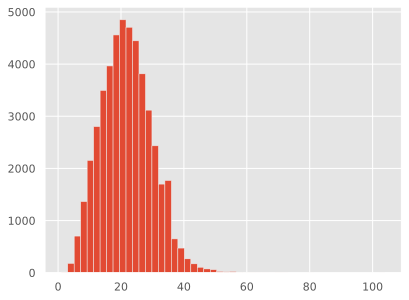

In [129]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [130]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 104


In [131]:
#Words tagged as B-org
data.loc[data['labels'] == 'B-org', 'words'].head()

97             Labor
154    International
215             IAEA
234         European
248             U.N.
Name: words, dtype: object

In [132]:
#Words tagged as I-org
data.loc[data['labels'] == 'I-org', 'words'].head()

98      Party
155    Atomic
156    Energy
157    Agency
235     Union
Name: words, dtype: object

In [43]:
import seaborn as sns

#Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot('labels',data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

TypeError: countplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1500x500 with 0 Axes>

In [44]:
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

In [138]:
data.head()

,sentence_id,words,POS,labels
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O


In [139]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    #postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
     #   'postag': postag,
     #   'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
     #   postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
   #         '-1:postag': postag1,
    #        '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
     #   postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
      #      '+1:postag': postag1,
       #     '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [143]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

In [144]:
%%time

#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

CPU times: user 3.65 s, sys: 221 ms, total: 3.87 s
Wall time: 4.37 s


In [145]:

print(X[0])
print(y[0:15])

print(len(X))
print(len(y))

[{'bias': 1.0, 'word.lower()': 'thousands', 'word[-3:]': 'nds', 'word[-2:]': 'ds', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'BOS': True, '+1:word.lower()': 'of', '+1:word.istitle()': False, '+1:word.isupper()': False}, {'bias': 1.0, 'word.lower()': 'of', 'word[-3:]': 'of', 'word[-2:]': 'of', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, '-1:word.lower()': 'thousands', '-1:word.istitle()': True, '-1:word.isupper()': False, '+1:word.lower()': 'demonstrators', '+1:word.istitle()': False, '+1:word.isupper()': False}, {'bias': 1.0, 'word.lower()': 'demonstrators', 'word[-3:]': 'ors', 'word[-2:]': 'rs', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, '-1:word.lower()': 'of', '-1:word.istitle()': False, '-1:word.isupper()': False, '+1:word.lower()': 'have', '+1:word.istitle()': False, '+1:word.isupper()': False}, {'bias': 1.0, 'word.lower()': 'have', 'word[-3:]': 'ave', 'word[-2:]': 've', 'word.isupper()'

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [147]:
print(len(X_train) , len(y_train), len(X_test), len(y_test))

38367 38367 9592 9592


In [148]:
X_val = X_test.copy()
y_val = y_test.copy()

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

In [150]:
print(len(X_train) , len(y_train), len(X_test), len(y_test),len(X_val), len(y_val))

30693 30693 7674 7674 9592 9592


In [151]:
#Creating the CRF model
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)


In [90]:
#Data analysis
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats



In [83]:
!pip install eli5
import eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=dada99e8e40edd1d4f222a4530930206562426fc716a2c7a2e4266fa0a6e533b
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [153]:
%%time
#We predcit using the same 5 fold cross validation
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=1000,
          all_possible_transitions=False)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
predictions = crf.predict(X_test)

CPU times: user 19min, sys: 5.93 s, total: 19min 6s
Wall time: 19min 22s


In [155]:
y_train_pred = crf.predict(X_train)
y_test_pred = crf.predict(X_test)
y_val_pred = crf.predict(X_val)

In [162]:
labels = list(crf.classes_)
labels

['O',
 'B-org',
 'B-per',
 'I-per',
 'B-geo',
 'B-tim',
 'I-geo',
 'B-gpe',
 'I-org',
 'I-tim',
 'B-art',
 'I-art',
 'I-gpe',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

In [160]:
print("Train F1-score:", metrics.flat_f1_score(y_train,y_train_pred, average='macro',labels=labels))
print("Test F1-score:", metrics.flat_f1_score(y_test,y_test_pred, average='macro',labels=labels))
print("Validation F1-score:", metrics.flat_f1_score(y_val,y_val_pred, average='weighted',labels=labels))



Train F1-score: 0.88538602849107
Test F1-score: 0.6295428299576049
Validation F1-score: 0.9687361904875875


In [163]:
%%time
print("Model evaluation metrics for train dataset")
print(flat_classification_report(y_pred=y_train_pred, y_true=y_train))

print("Model evaluation metrics for test dataset")
print(flat_classification_report(y_pred=y_test_pred, y_true=y_test))

print("Model evaluation metrics for Val dataset")
print(flat_classification_report(y_pred=y_val_pred, y_true=y_val))

##report = flat_classification_report(y_pred=pred, y_true=y)
#print(report)

Model evaluation metrics for train dataset
              precision    recall  f1-score   support

       B-art       0.92      0.68      0.78       247
       B-eve       0.87      0.73      0.79       193
       B-geo       0.91      0.95      0.93     24009
       B-gpe       0.98      0.96      0.97     10106
       B-nat       0.88      0.67      0.76       126
       B-org       0.92      0.85      0.89     12945
       B-per       0.95      0.93      0.94     10918
       B-tim       0.96      0.93      0.95     12922
       I-art       0.95      0.79      0.86       183
       I-eve       0.87      0.75      0.80       157
       I-geo       0.91      0.93      0.92      4713
       I-gpe       0.99      0.67      0.80       122
       I-nat       0.96      0.76      0.85        29
       I-org       0.95      0.94      0.94     10688
       I-per       0.94      0.96      0.95     11032
       I-tim       0.94      0.90      0.92      4121
           O       1.00      1.00     

In [164]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

In [115]:
from collections import Counter

In [166]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

Top likely transitions:
B-geo  -> I-geo   12.169285
B-per  -> I-per   11.626877
B-tim  -> I-tim   10.135371
I-per  -> I-per   9.459382
I-geo  -> I-geo   9.290563
B-org  -> I-org   9.227148
I-tim  -> I-tim   9.097124
I-org  -> I-org   8.980181
B-art  -> I-art   7.753820
I-eve  -> I-eve   7.598324
I-art  -> I-art   7.528331
B-eve  -> I-eve   7.215390
O      -> B-per   6.874019
B-nat  -> I-nat   6.350902
B-gpe  -> I-gpe   6.310354
O      -> B-tim   5.636777
O      -> B-org   5.626709
I-gpe  -> I-gpe   5.313979
O      -> O       5.256330
B-per  -> B-org   5.168658


In [167]:
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])



Top unlikely transitions:
B-org  -> O       0.486613
I-gpe  -> B-per   0.335206
I-tim  -> B-eve   0.288400
I-gpe  -> B-geo   0.262529
I-eve  -> O       0.203654
I-org  -> B-geo   0.196380
B-org  -> B-eve   0.140726
B-art  -> B-geo   0.075363
I-org  -> O       -0.145415
I-tim  -> B-gpe   -0.177432
I-tim  -> O       -0.200704
I-geo  -> B-gpe   -0.316178
I-per  -> B-geo   -0.399709
I-geo  -> O       -0.451601
B-nat  -> O       -0.624926
B-art  -> O       -0.766541
I-gpe  -> O       -0.896696
I-art  -> O       -1.094595
B-eve  -> O       -1.170437
I-nat  -> O       -1.419632


Conclusion on CRF

NER tagging by Deep Learning (Tensrflow)

In [231]:
print(data.head())
print(data.shape)

   sentence_id          words  POS labels
0            0      Thousands  NNS      O
1            0             of   IN      O
2            0  demonstrators  NNS      O
3            0           have  VBP      O
4            0        marched  VBN      O
(1048575, 4)


In [243]:
words = pd.DataFrame(data.groupby('sentence_id')['words'].apply(list))
tags = data.groupby('sentence_id')['labels'].apply(list)
words['tag'] = tags
words['sentence'] = words['words'].apply(lambda x: ' '.join(x))
words['tag_combine'] = words['tag'].apply(lambda x: ' '.join(x))
words = words.reset_index()
words.head()

,sentence_id,words,tag,sentence,tag_combine
0,0,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...",Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,1,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...",Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,2,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...",Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,3,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]",They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,4,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...",U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


In [245]:
spacy_data = []
for idx, row in words.iterrows():
    tokens = row['words']
    tags = row['tag']
    entities = [
        (len(' '.join(tokens[:i])) + 1, len(' '.join(tokens[:i])) + len(tokens[i]) + 1, tags[i])
        if i != 0 else
        (len(' '.join(tokens[:i])), len(' '.join(tokens[:i])) + len(tokens[i]), tags[i])
        for i in range(len(tags)) if tags[i] != 'O'
    ]
    data_tuple = (row['sentence'], {'entities': entities})
    spacy_data.append(data_tuple)
spacy_data[:5]

[('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
  {'entities': [(48, 54, 'B-geo'), (77, 81, 'B-geo'), (111, 118, 'B-gpe')]}),
 ('Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .',
  {'entities': [(0, 7, 'B-gpe'), (87, 96, 'B-tim'), (108, 112, 'B-org')]}),
 ('Helicopter gunships Saturday pounded militant hideouts in the Orakzai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South Waziristan .',
  {'entities': [(20, 28, 'B-tim'),
    (62, 69, 'B-geo'),
    (97, 104, 'B-org'),
    (190, 195, 'B-geo'),
    (196, 206, 'I-geo')]}),
 ('They left after a tense hour-long standoff with riot police .',
  {'entities': []}),
 ('U.N. relief coordinator Jan Egeland said Sunday , U.S. , Indonesian and Australian military heli

In [248]:
def num_words_tags (tags, data):

    """This functions takes the tags we want to count and the datafram
    and return a dict where the key is the tag and the value is the frequency
    of that tag"""

    tags_count = {}

    for tag in tags:
        len_tag = len(data[data['labels'] == tag])
        tags_count[tag] = len_tag

    return tags_count

tags = data["labels"].unique()
tags_count = num_words_tags(tags, data)
tags_count

{'O': 887908,
 'B-geo': 37644,
 'B-gpe': 15870,
 'B-per': 16990,
 'I-geo': 7414,
 'B-org': 20143,
 'I-org': 16784,
 'B-tim': 20333,
 'B-art': 402,
 'I-art': 297,
 'I-per': 17251,
 'I-gpe': 198,
 'I-tim': 6528,
 'B-nat': 201,
 'B-eve': 308,
 'I-eve': 253,
 'I-nat': 51}

In [249]:
X = list(words['sentence'])
Y = list(words['tag'])

In [250]:
print(X[0])
print(Y[0])

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [251]:
from ast import literal_eval
Y_ready = []
for sen_tags in Y:
    Y_ready.append(literal_eval(str(sen_tags)))

In [252]:
# cutoff reviews after 110 words
maxlen = 110

# consider the top 36000 words in the dataset
max_words = 36000

# tokenize each sentence in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
print(tokenizer)

In [253]:
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 27953 unique tokens.


In [254]:
ind2word = dict([(value, key) for (key, value) in word_index.items()])
word2id = word_index
id2word = {}
for key, value in word2id.items():
    id2word[value] = key

In [257]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [258]:
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')
X_preprocessed[0]

array([ 260,    3,  997,   13, 1838,  245,  452,    4,  545,    1,  121,
          2,   60,    6,  595,    1,  861,    3,  184,   89,   21,   12,
         54,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [259]:
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i
tags2id

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [260]:
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key
id2tag

{0: 'O',
 1: 'B-geo',
 2: 'B-gpe',
 3: 'B-per',
 4: 'I-geo',
 5: 'B-org',
 6: 'I-org',
 7: 'B-tim',
 8: 'B-art',
 9: 'I-art',
 10: 'I-per',
 11: 'I-gpe',
 12: 'I-tim',
 13: 'B-nat',
 14: 'B-eve',
 15: 'I-eve',
 16: 'I-nat'}

In [261]:
def preprocess_tags(tags2id, Y_ready):

    Y_preprocessed = []
    maxlen = 110
    i = 0
    # for each target
    for y in Y_ready:
        j = 0
        # place holder to store the new preprocessed tag list
        Y_place_holder = []

        # for each tag in rhe tag list
        for tag in y:
            if(j >= 110):
                pass
            else:
                Y_place_holder.append(tags2id[tag])
            j +=1

        # find the lenght of the new preprocessed tag list
        len_new_tag_list = len(Y_place_holder)
        # find the differance in length between the len of tag list and padded sentences
        num_O_to_add = maxlen - len_new_tag_list

        # add 'O's to padd the tag lists
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)

    return Y_preprocessed

In [262]:
Y_preprocessed = preprocess_tags(tags2id, Y_ready)
print("The Lenght of training examples: {}".format(len(X_preprocessed)))
print("The Lenght of training targets: {}".format(len(Y_preprocessed)))

The Lenght of training examples: 47959
The Lenght of training targets: 47959


In [263]:
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)

In [264]:
# 70% of the datat will be used for training
training_samples = 0.6
# 15% of the datat will be used for validation
validation_samples = 0.20
# 15% of the datat will be used for testing
testing_samples = 0.20

In [265]:
indices = np.arange(len(Y_preprocessed))
np.random.seed(seed=555)
np.random.shuffle(indices)
X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

X_train = X_preprocessed[: int(0.7 * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))


X_val = X_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
print("Number of validation examples: {}".format(len(X_val)))


X_test = X_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]
print("Number of testing examples: {}".format(len(X_test)))


Y_train = Y_preprocessed[: int(0.7 * len(X_preprocessed))]
Y_val = Y_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
Y_test = Y_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_val) + len(X_test)))

Number of training examples: 33571
Number of validation examples: 7194
Number of testing examples: 7194
Total number of examples after shuffling and splitting: 47959


In [266]:
X_train = X_train.reshape(-1, 1, 110)
X_val  = X_val.reshape(-1, 1, 110)
X_test = X_test.reshape(-1, 1, 110)
Y_train = Y_train.reshape(-1, 1, 110)
Y_val = Y_val.reshape(-1, 1, 110)
Y_test = Y_test.reshape(-1, 1, 110)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))


In [267]:
embedding_dim = 300
maxlen = 110
max_words = 36000
num_tags = len(tags)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 110, 300)          10800000  
                                                                 
 bidirectional_2 (Bidirecti  (None, 110, 200)          320800    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 110, 200)          240800    
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 110, 17)           3417      
 stributed)                                                      
                                                                 
Total params: 11365017 (43.35 MB)
Trainable params: 11365017 (43.35 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [268]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
%%time

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=3)

Epoch 1/3
 2565/33571 [=>............................] - ETA: 3:59:53 - loss: 0.1254 - accuracy: 0.9708

In [169]:
## here we will use the same sentence getter function used previosuly

sentences = getter.sentences
#ths is how a sentence will look like.
print(sentences[1])


[('Iranian', 'B-gpe'), ('officials', 'O'), ('say', 'O'), ('they', 'O'), ('expect', 'O'), ('to', 'O'), ('get', 'O'), ('access', 'O'), ('to', 'O'), ('sealed', 'O'), ('sensitive', 'O'), ('parts', 'O'), ('of', 'O'), ('the', 'O'), ('plant', 'O'), ('Wednesday', 'B-tim'), (',', 'O'), ('after', 'O'), ('an', 'O'), ('IAEA', 'B-org'), ('surveillance', 'O'), ('system', 'O'), ('begins', 'O'), ('functioning', 'O'), ('.', 'O')]


Number of Sentences: 47959
Maximum sequence length: 104
Number of unique words: 35178


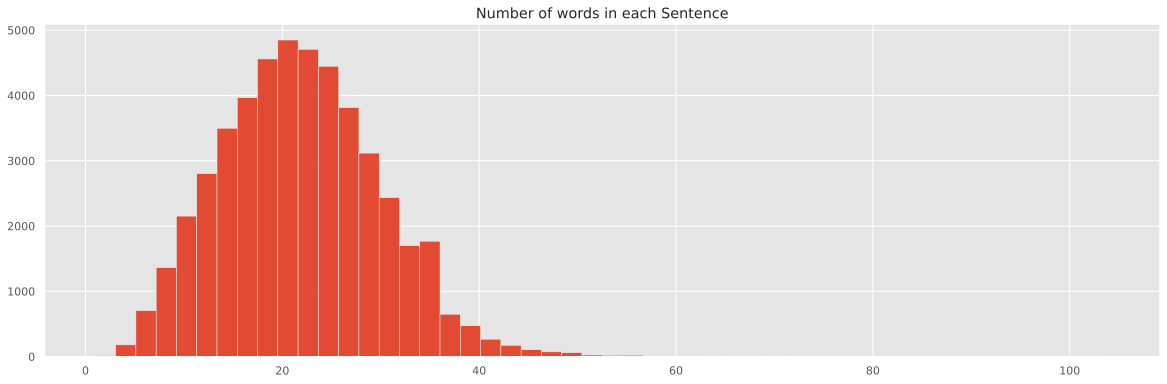

In [171]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in sentences])
print('Number of Sentences:', len(sentences))
print ('Maximum sequence length:', maxlen)

words = list(set(data["words"].values))
words.append("ENDPAD")
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique Tags: 17


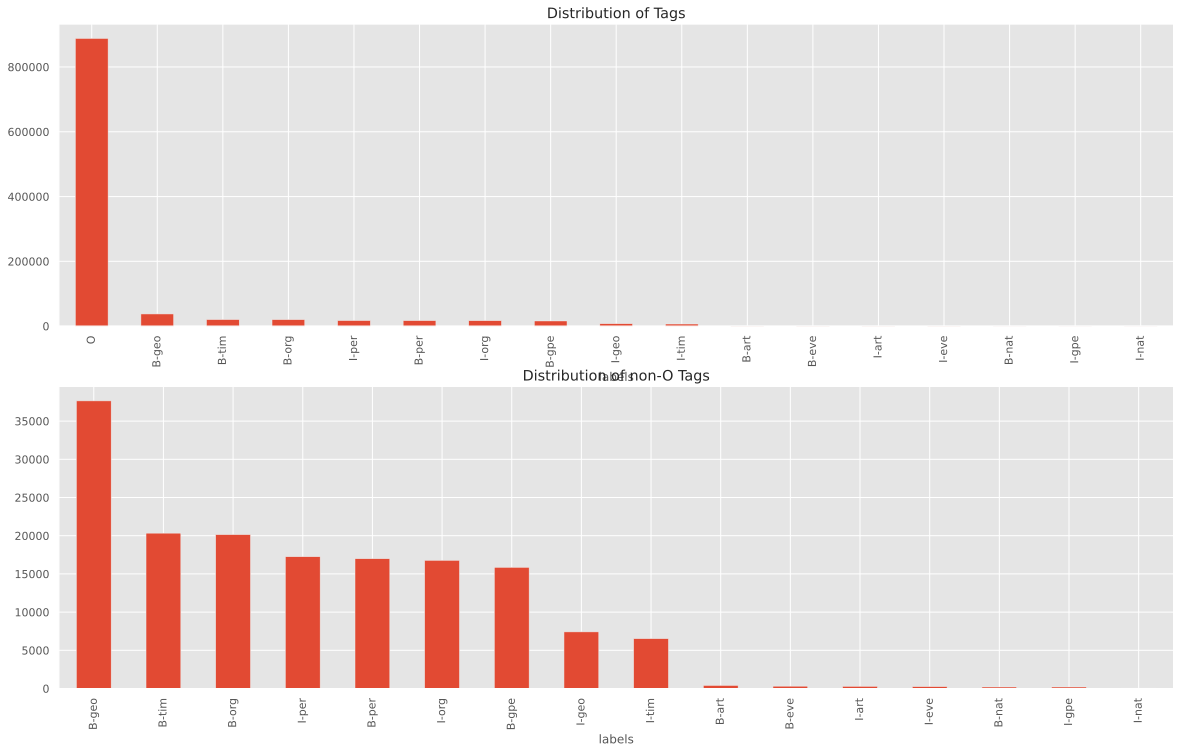

In [173]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.labels.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.labels != 'O'].labels.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["labels"].values))
n_tags = len(labels)
print('Number of unique Tags:', n_tags)

In [232]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(labels)}

In [233]:
type(tag2idx)

print(len(tag2idx))

print(tag2idx)

17
{'O': 0, 'B-org': 1, 'B-per': 2, 'I-per': 3, 'B-geo': 4, 'B-tim': 5, 'I-geo': 6, 'B-gpe': 7, 'I-org': 8, 'I-tim': 9, 'B-art': 10, 'I-art': 11, 'I-gpe': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}


MOdelling

In [234]:
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical

In [235]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape)

X shape (47959, 104) y shape (47959, 104, 17)


In [236]:
print('X shape', X.shape, 'y shape', y.shape)

X shape (47959, 104) y shape (47959, 104, 17)


In [238]:
print(X[0])

[10468 34652 27094 29518 25112 17255 20153  5508 27901    50 29260  6051
 23643 25889  9725    50  4379 34652  1933 28504 13275 17486  2616  4104
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177]


In [239]:
print(X[10])

[ 4311 29293  8067 10826   124 34652 10730 30326 15293 34121  8067  8692
  5686    50 26523 13666 34493  6051 29897 28996  8067 13040 16797 18937
 25207   540    50 26025  4362 12753  2712  6051  6335 26205 31453 13275
 15024 15293 31596  4104 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177]


In [240]:
class config():
    VOCAB = n_words
    MAX_LEN = maxlen
    N_OUPUT = n_tags


    EMBEDDING_VECTOR_LENGTH = 50
    N_LSTM_CELLS = 64
    RECURRENT_DROPOUT = 0.1

    OUTPUT_ACTIVATION = 'softmax'

    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']

    MAX_EPOCHS = 10

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 104, 50)           1758900   
                                                                 
 bidirectional_1 (Bidirecti  (None, 104, 128)          58880     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 104, 17)           2193      
 stributed)                                                      
                                                                 
Total params: 1819973 (6.94 MB)
Trainable params: 1819973 (6.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


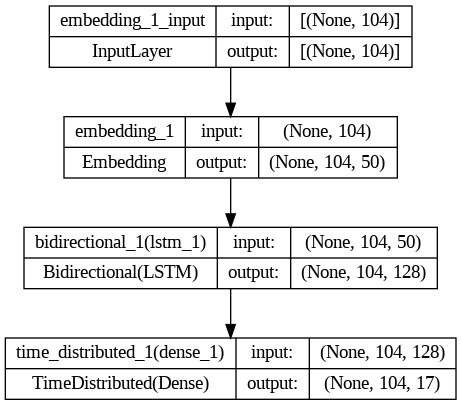

In [241]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

model = Sequential()
model.add(
    Embedding(
        input_dim=config.VOCAB, output_dim=config.EMBEDDING_VECTOR_LENGTH, input_length=config.MAX_LEN
    )
)
model.add(
    Bidirectional(
        LSTM(config.N_LSTM_CELLS, return_sequences=True, recurrent_dropout=config.RECURRENT_DROPOUT)
    )
)
model.add(
    TimeDistributed(
        Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)
    )
)
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model.summary()
plot_model(model, show_shapes=True)

In [180]:
%%time

history = model.fit(x=X, y=y, validation_split=0.2,
    callbacks=[es, ckpt, rlp], epochs=config.MAX_EPOCHS
)

Epoch 1/10
1199/1199 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9867
Epoch 1: loss improved from inf to 0.04694, saving model to model.h5
1199/1199 [==============================] - 342s 285ms/step - loss: 0.0469 - accuracy: 0.9867 - val_loss: 0.0294 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1199/1199 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9935
Epoch 2: loss improved from 0.04694 to 0.02188, saving model to model.h5
1199/1199 [==============================] - 342s 285ms/step - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.0257 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 3/10
1199/1199 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9949
Epoch 3: loss improved from 0.02188 to 0.01665, saving model to model.h5
1199/1199 [==============================] - 343s 286ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 0.0248 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 4/10
1199/1199 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9957
Epoch 4: loss improved from 0.01665 to 0.01371, saving model to model.h5
1199/1199 [==============================] - 349s 291ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0255 - val_accuracy: 0.9927 - lr: 0.0010
Epoch 5/10
1199/1199 [==========================

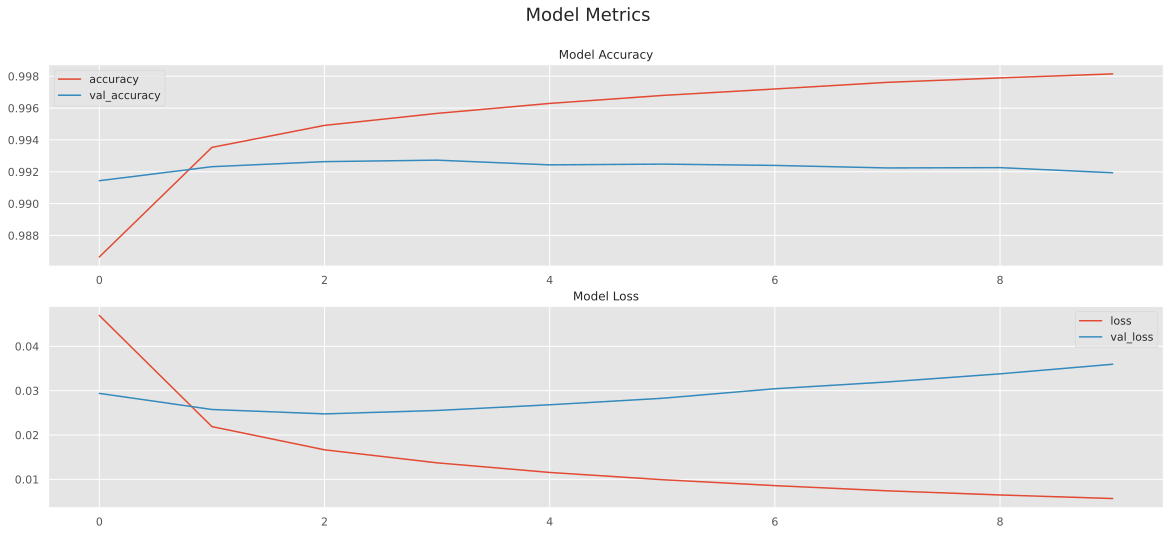

In [181]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [182]:
df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.046941,0.986652,0.029377,0.991439,0.001
1,0.021883,0.993532,0.025746,0.992318,0.001
2,0.016650,0.994913,0.024753,0.992636,0.001
3,0.013712,0.995668,0.025524,0.992729,0.001
4,0.011548,0.996293,0.026813,0.992434,0.001


In [183]:
type(history)

keras.src.callbacks.History

In [186]:
print(history.params)

{'verbose': 1, 'epochs': 10, 'steps': 1199}


In [206]:
# predict probabilities for test set
##yhat_probs = history.model.predict(X, verbose=1)
# predict crisp classes for test set
###yhat_classes = history.model.predict(y, verbose=1)

p = history.model.predict(X,verbose = 1)
yhat_classes = np.argmax(p, axis=-1)

1499/1499 [==============================] - 68s 45ms/step


In [211]:
print(p.shape)
print(y.shape)
print(tags[p[0]])


(47959, 104, 17)
(47959, 104, 17)


TypeError: only integer scalar arrays can be converted to a scalar index

In [190]:
print(yhat_probs)

[[[9.99986351e-01 2.98005801e-07 1.17595584e-06 ... 4.45741613e-08
   3.65322350e-08 9.23933783e-08]
  [9.99997914e-01 7.70259163e-08 4.34023093e-08 ... 7.41571959e-09
   8.39449310e-09 5.30102939e-09]
  [9.99978244e-01 3.40594033e-06 3.50034315e-06 ... 4.89931073e-09
   3.25968003e-10 1.09610855e-10]
  ...
  [9.99999940e-01 4.75902789e-11 1.97828934e-10 ... 2.66107913e-10
   7.69668107e-10 1.29006264e-10]
  [9.99999821e-01 1.05143771e-09 4.01320532e-09 ... 9.47951495e-09
   2.34917135e-08 7.20212201e-09]
  [9.99992073e-01 8.44448778e-08 1.57052540e-07 ... 6.43556859e-07
   1.53910128e-06 5.86985948e-07]]

 [[1.15839539e-05 2.79431930e-04 2.36344317e-06 ... 2.69969933e-05
   2.67476776e-06 4.52013822e-08]
  [9.99999821e-01 4.20332746e-08 4.30666844e-08 ... 5.22617638e-09
   7.90206744e-09 6.24948482e-10]
  [9.99999821e-01 1.76752728e-08 3.18423545e-08 ... 1.71516257e-09
   1.64547131e-09 1.70986045e-10]
  ...
  [9.99999940e-01 4.75701319e-11 1.97635450e-10 ... 2.64897104e-10
   7.66892

In [228]:
i  = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD':
        break

1/1 [==============================] - 0s 69ms/step
Word           True 	Pred
------------------------------
For            B-nat	B-nat
the            B-nat	B-nat
last           B-nat	B-nat
four           B-org	B-org
weeks          B-nat	B-nat
a              B-nat	B-nat
team           B-nat	B-nat
led            B-nat	B-nat
by             B-nat	B-nat
former         B-nat	B-nat
UN             B-per	B-per
Secretary-GeneralI-org	I-org
Kofi           I-per	I-per
Annan          B-eve	B-eve
has            B-nat	B-nat
been           B-nat	B-nat
trying         B-nat	B-nat
to             B-nat	B-nat
broker         B-nat	B-nat
a              B-nat	B-nat
deal           B-nat	B-nat
between        B-nat	B-nat
the            B-nat	B-nat
Kenyan         I-eve	I-eve
government     B-nat	B-nat
of             B-nat	B-nat
President      I-per	I-per
Mwai           B-eve	B-eve
Kibaki         B-eve	B-eve
and            B-nat	B-nat
the            B-nat	B-nat
opposition     B-nat	B-nat
led            B-nat	B-na

In [230]:
#Predict
y_prediction = history.model.predict(X)
y_prediction = np.argmax(y_prediction, axis = 1)
y=np.argmax(y, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y, y_prediction , normalize='pred')
print(result)




1499/1499 [==============================] - 71s 47ms/step


ValueError: multiclass-multioutput is not supported

In [221]:
print(history.model)